<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Likhitha/09_bert_finetuning_classification_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 Using device: cpu
Total samples: 16 (Positive: 8, Negative: 8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1: 100%|██████████| 3/3 [00:41<00:00, 13.92s/it, loss=0.534, acc=0.417]


Epoch 1 - Train Loss: 0.7123, Acc: 0.4167 | Test Acc: 0.5000


Epoch 2: 100%|██████████| 3/3 [00:18<00:00,  6.25s/it, loss=0.466, acc=0.833]


Epoch 2 - Train Loss: 0.6208, Acc: 0.8333 | Test Acc: 0.5000


Epoch 3: 100%|██████████| 3/3 [00:20<00:00,  6.77s/it, loss=0.474, acc=0.667]


Epoch 3 - Train Loss: 0.6319, Acc: 0.6667 | Test Acc: 0.5000


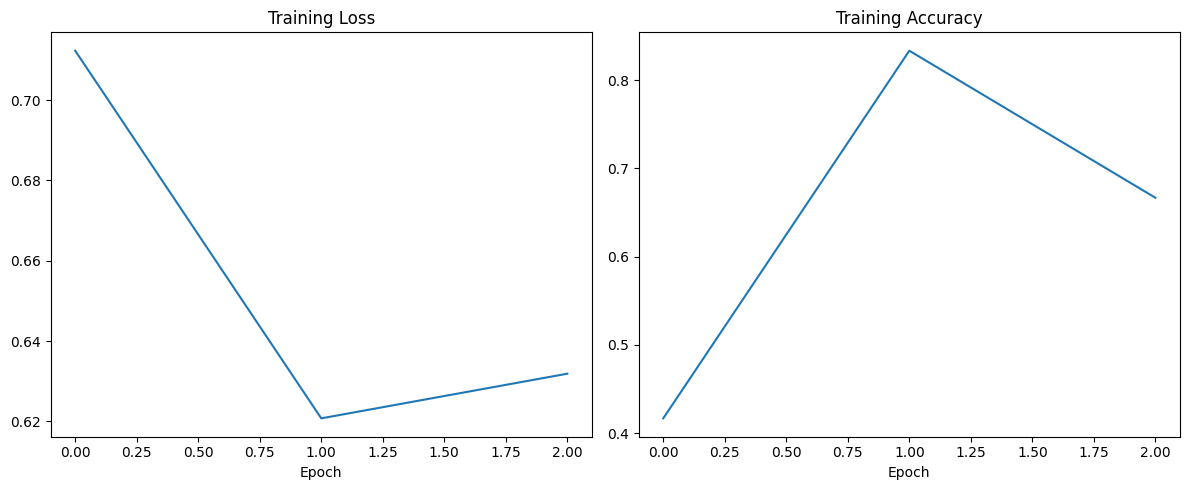


Final Evaluation:
Test Accuracy: 0.5000

Example Predictions:

Text: This is absolutely wonderful!
Prediction: Positive
Confidence: 0.5219

Text: Terrible product, don't buy
Prediction: Negative
Confidence: 0.5274

Text: It's okay, nothing special
Prediction: Positive
Confidence: 0.5280


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Custom Dataset Class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create a larger sample dataset
def create_sample_data():
    positive_samples = [
        ("This product is amazing!", 1),
        ("Excellent quality and fast shipping", 1),
        ("Highly recommend this to everyone", 1),
        ("Works perfectly, very satisfied", 1),
        ("Best purchase I've made this year", 1),
        ("Great value for the price", 1),
        ("Exactly what I was looking for", 1),
        ("Very impressed with this product", 1)
    ]

    negative_samples = [
        ("Terrible experience, would not buy again", 0),
        ("Poor quality and doesn't work", 0),
        ("Waste of money", 0),
        ("Not as described", 0),
        ("Defective product", 0),
        ("Very disappointed", 0),
        ("Much worse than expected", 0),
        ("Broken upon arrival", 0)
    ]

    all_samples = positive_samples + negative_samples
    texts, labels = zip(*all_samples)
    return list(texts), list(labels)

# Prepare data loaders with fixed split sizes
def prepare_data_loaders(texts, labels, tokenizer, test_size=4, batch_size=4):
    # Ensure we have at least one sample per class in test set
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels,
        test_size=test_size,
        random_state=42,
        stratify=labels
    )

    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Training function
def train_model(model, train_loader, test_loader, epochs=3, lr=2e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * epochs
    )

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix({
                'loss': total_loss/(total/len(train_loader)),
                'acc': correct/total
            })

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Evaluate
        test_acc = evaluate(model, test_loader)
        print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Acc: {accuracy:.4f} | Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Main execution
if __name__ == "__main__":
    # Create larger sample dataset
    texts, labels = create_sample_data()
    print(f"Total samples: {len(texts)} (Positive: {sum(labels)}, Negative: {len(labels)-sum(labels)})")

    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)

    # Prepare data loaders with fixed test size
    train_loader, test_loader = prepare_data_loaders(texts, labels, tokenizer, test_size=4)

    # Train the model
    train_losses, train_accuracies = train_model(model, train_loader, test_loader, epochs=3)

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

    # Final evaluation
    print("\nFinal Evaluation:")
    test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Example predictions
    print("\nExample Predictions:")
    test_samples = [
        "This is absolutely wonderful!",
        "Terrible product, don't buy",
        "It's okay, nothing special"
    ]

    model.eval()
    for sample in test_samples:
        inputs = tokenizer(sample, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs).item()

        print(f"\nText: {sample}")
        print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
        print(f"Confidence: {probs[0][pred]:.4f}")